<a href="https://colab.research.google.com/github/yohanesnuwara/pyresim/blob/master/simulators/advanced/PyReSim_advanced1d_case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!git clone https://github.com/yohanesnuwara/pyresim

Cloning into 'pyresim'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 738 (delta 124), reused 0 (delta 0), pack-reused 514
Receiving objects: 100% (738/738), 248.65 KiB | 4.08 MiB/s, done.
Resolving deltas: 100% (418/418), done.


In [3]:
import sys
sys.path.append('/content/pyresim/functions')

In [4]:
from input_output import read_input, read_depth
from boundary import boundary_floweq1d
from gridding import source1d
from solver import lhs_coeffs1d_welltype, rhs_constant1d_welltype
from transmissibility import transmissibility1d, transmissibility1d_boundary
from wellblock import fraction_wellblock_geometric_factor
from wellsimulation import solution_well1d
from potential import potential_term1d

## Simulation

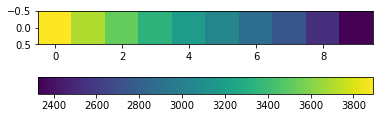

In [6]:
import warnings
warnings.filterwarnings("ignore")

"""""""""""
PUT THE INPUT TXT DATA
"""""""""""

filepath = '/content/pyresim/input/advanced/advanced1d_input.txt'

# call the read_input function to read input data
reservoir_input, wells, west, east = read_input(filepath)

"""""""""""
ADD ELEVATION

N.b.: there are 2 approaches to add elevation in case of ELEVATED grid block
      * upload the depth input file using function 'read_depth'
      * create synthetic depth data using Numpy method in Python
"""""""""""

## Read or create synthetic depth data
depthpath = '/content/pyresim/input/advanced/advanced1d_depth.txt'
x, depth = read_depth(depthpath)

## Boundary depth (if not elevated, leave both with ZEROS)
## then add to the 'west_boundary' and 'east_boundary' already created before
west_depth, east_depth = 4000, 2900
west['depth'] = west_depth 
east['depth'] = east_depth

"""""""""""
INPUT PROCESSING
"""""""""""

# number of blocks in x and y
xi = reservoir_input['xi']

# define parameters, in this case blocks are homogeneous and same in size
dx = reservoir_input['dx'] 
dy = reservoir_input['dy']
dz = reservoir_input['dz']
kx = reservoir_input['kx']
B = reservoir_input['B']
mu = reservoir_input['mu']
rho = reservoir_input['rho']

# well information (dataframe)
well_name = wells['well_name']
well_rw = wells['well_rw'] / 12  # wellbore radius, inch to ft
well_skin = wells['well_skin']
well_loc = wells['well_loc']
well_condition = wells['well_rw']
well_value = wells['well_value']
well_config = wells['well_config']

"""""""""""
GRIDDING
"""""""""""

# calculate elevation
elev = [j - i for i, j in zip(depth[:-1], depth[1:])]


"""""""""""
WELL INFORMATION PROCESSING
"""""""""""

# source block (production or injection well)
well_loc = np.array(well_loc).astype(int)
qsc = source1d(well_value, well_loc, xi)  # call function HERE

# Calculate wellblock geometric factor
kh, r_eq, Gw = [], [], []

for i in range(len(well_config)):
    kh_, r_eq_, Gw_ = fraction_wellblock_geometric_factor(dx, dy, kx, kx, well_skin[i],
                                                          well_rw[i], dz, well_config[i])
    kh.append(kh_);
    r_eq.append(r_eq_);
    Gw.append(Gw_)

# create dataframe from the created dictionary
well_df = pd.DataFrame.from_dict(wells)

well_mu = np.full(len(well_loc), mu)
well_B = np.full(len(well_loc), B)
well_dz = np.full(len(well_loc), dz)

well_df['well_loc'] = well_loc
well_df['well_dz'] = dz
well_df['well_kh'] = kh
well_df['well_mu'] = mu
well_df['well_B'] = B
well_df['well_Gw'] = Gw

"""""""""""
SIMULATION
"""""""""""

T_min_array, T_plus_array = np.zeros(xi), np.zeros(xi)
lhs_mat = np.array([[0.] * xi] * xi)
rhs_mat = np.array([[0.] * 1] * xi)

for i in range(xi):

    T_min, T_plus = transmissibility1d(dx, dy, dz, kx, mu, B)

    if i == 0:
        # left boundary

        ## flow rate from boundary
        qsc_b = boundary_floweq1d(west['type'], dx, dy, dz, kx, mu, B, value=west['value'], no_block=(i + 1))

        ## LHS coeffs
        T_plus = T_plus
        T_min = transmissibility1d_boundary(west['type'], dx, dy, dz, kx, mu, B)

        p_plus, p_min, p = lhs_coeffs1d_welltype('west', (i + 1), well_df, qsc, T_plus, T_min)

        ## calculate potential term for the RHS constant
        potential_term = potential_term1d(rho, T_min, T_plus, west['depth'], depth[i], depth[i + 1])

        ## RHS constants
        # rhs = rhs_constant('incompressible', west['type'], qsc[i], T_pb=T_min, p_b=west['value'])
        rhs = rhs_constant1d_welltype('incompressible', west['type'], (i + 1), well_df, potential_term, qsc_b, T_pb=T_min,
                                    p_b=west['value'])

        ## fill in LHS matrix (lhs_mat)
        lhs_mat[i, i] = p
        lhs_mat[i, i + 1] = p_plus

        ## fill in RHS matrix (rhs_mat)   
        rhs_mat[i, 0] = rhs

    elif i == xi - 1:
        # right boundary

        ## flow rate from boundary
        qsc_b = boundary_floweq1d(east['type'], dx, dy, dz, kx, mu, B, value=east['value'], no_block=(i + 1))

        ## LHS coeffs
        T_plus = transmissibility1d_boundary(east['type'], dx, dy, dz, kx, mu, B)
        T_min = T_min
        p_plus, p_min, p = lhs_coeffs1d_welltype('east', (i + 1), well_df, qsc, T_plus, T_min)

        ## calculate potential term for the RHS constant
        potential_term = potential_term1d(rho, T_min, T_plus, depth[i - 1], depth[i], east['depth'])

        ## RHS constants      
        # rhs = rhs_constant('incompressible', east['type'], qsc[i])    
        rhs = rhs_constant1d_welltype('incompressible', east['type'], (i + 1), well_df, potential_term, qsc_b,
                                    T_pb=T_plus, p_b=east['value'])

        ## fill in LHS matrix (lhs_mat)
        lhs_mat[i, i - 1] = p_min
        lhs_mat[i, i] = p

        ## fill in RHS matrix (rhs_mat)    
        rhs_mat[i, 0] = rhs

    else:

        ## calculate potential term for the RHS constant

        T_plus, T_min = T_plus, T_min
        p_plus, p_min, p = lhs_coeffs1d_welltype(None, (i+1), well_df, qsc, T_plus, T_min) 
        # p_plus, p_min, p = lhs_coeffs1d(None, T_plus, T_min)

        ## calculate potential term for the RHS constant
        potential_term = potential_term1d(rho, T_min, T_plus, depth[i - 1], depth[i], depth[i + 1])

        ## RHS constants      
        rhs = -qsc[i] + potential_term

        ## fill in LHS matrix (lhs_mat)
        lhs_mat[i, i - 1] = p_min
        lhs_mat[i, i] = p
        lhs_mat[i, i + 1] = p_plus

        ## fill in RHS matrix (rhs_mat)    
        rhs_mat[i, 0] = rhs

        # print the transmissibility
    T_min_array[i], T_plus_array[i] = T_min, T_plus

"""""""""""
PRESSURE SOLVER
"""""""""""

p_sol = np.linalg.solve(lhs_mat, rhs_mat)

"""""""""""
DISPLAY PRESSURE
"""""""""""

p_sol = p_sol.T.reshape(-1)
p_sol_ = np.expand_dims(p_sol, axis=0)  # or axis=1
plt.imshow(p_sol_)
plt.colorbar(orientation='horizontal')
plt.show() 

In [7]:
"""""""""""
WELL SIMULATION
"""""""""""

well_report = solution_well1d(well_df, p_sol)
well_report = well_report.drop(['well_dz', 'well_kh', 'well_mu', 'well_B', 'well_Gw'], 1)
well_report

,well_name,well_loc,well_rw,well_skin,well_condition,well_value,well_config,fbhp_sol,rate_sol
0,A,1,3.5,1.5,constant_fbhp,3900.0,0.0,3900.000000,22.146555
1,B,4,2.5,0.1,constant_rate,-150.0,0.0,3298.778255,-150.000000
2,C,6,2.0,0.0,shutin,0.0,0.0,3043.338826,0.000000
3,D,8,4.0,0.1,constant_rate,250.0,0.0,2809.230089,250.000000
4,E,10,3.5,0.0,constant_rate,-100.0,2.0,2275.923353,-100.000000
